# EDA & Preprocesado — TFM Sentidata (desde `params.yaml`)

Esta libreta:
- Lee su configuración desde **`params.yaml`** (sección `eda:`) para mantener coherencia con DVC.
- Explora el dataset (distribución de clases, longitudes, duplicados, idioma).
- Propone `max_len` recomendado.
- Aplica limpieza mínima de texto.
- Guarda tablas/figuras en `reports/eda/` con marca temporal.

> **Nota**: No entrena modelos; es complemento visual/narrativo del pipeline.


In [6]:
# ========= Carga de parámetros desde params.yaml =========
from pathlib import Path
import yaml
from datetime import datetime
import pandas as pd

# 1) 
PARAMS_FILE = Path("../params.yaml")

with open(PARAMS_FILE, "r") as f:
    params = yaml.safe_load(f)

# Sección específica para EDA
eda_params = params.get("eda", {})

from pathlib import Path as _P
DATA_PATH    = _P(eda_params.get("data_path", "data/trusted/sephora_clean/reviews_0_250.parquet"))
TEXT_COLUMN  = eda_params.get("text_column", "review_text")
STAR_COLUMN  = eda_params.get("star_column", "rating")
LABEL_COLUMN = eda_params.get("label_column", None)
STAR_TO_LABEL = eda_params.get("star_to_label", {1:"NEG", 2:"NEG", 3:"NEU", 4:"POS", 5:"POS"})
HF_MODEL_NAME = eda_params.get("hf_model_name", None)

# Carpeta de salida para reportes
REPORT_DIR = _P('reports/eda') / datetime.now().strftime('%Y%m%d_%H%M%S')
REPORT_DIR.mkdir(parents=True, exist_ok=True)

print("Usando params desde:", PARAMS_FILE.resolve())
print('REPORT_DIR =>', REPORT_DIR.resolve())

# Resumen visible de parámetros
summary_params = pd.DataFrame([{
    "DATA_PATH": str(DATA_PATH),
    "TEXT_COLUMN": TEXT_COLUMN,
    "STAR_COLUMN": STAR_COLUMN,
    "LABEL_COLUMN": LABEL_COLUMN,
    "HF_MODEL_NAME": HF_MODEL_NAME
}]).T
summary_params.columns = ["value"]
summary_params


Usando params desde: /home/pedro/MASTER_BIGDATA/TFM/TFM-Sentidata/params.yaml
REPORT_DIR => /home/pedro/MASTER_BIGDATA/TFM/TFM-Sentidata/notebooks/reports/eda/20250909_202117


,value
DATA_PATH,../data/trusted/sephora_clean/reviews_0_250
TEXT_COLUMN,review_text
STAR_COLUMN,rating
LABEL_COLUMN,None
HF_MODEL_NAME,albert-base-v2


In [7]:
# ========= Imports =========
import re
import json
import math
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

# Intento de import opcional para Hugging Face (tokenización real)
try:
    from transformers import AutoTokenizer
except Exception:
    AutoTokenizer = None


In [8]:
from pathlib import Path
p = Path(DATA_PATH)
print("DATA_PATH:", p.resolve())
if p.is_dir():
    print("Primeros .parquet detectados:")
    for i, f in enumerate(sorted(p.rglob("*.parquet"))[:5], 1):
        print(f"  {i:02d} ->", f)


# ========= Carga de datos (carpeta o archivo) =========
from pathlib import Path
import pandas as pd

def load_dataframe(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f'No existe la ruta: {path}')

    # Si es carpeta: concatenamos todos los .parquet dentro (recursivo)
    if path.is_dir():
        files = sorted(path.rglob("*.parquet"))
        if not files:
            # Pista si fuera Delta Lake:
            # si ves _delta_log aquí, es una tabla Delta (úsalo con pyarrow.dataset + deltalake/duckdb, etc.)
            raise FileNotFoundError(f"No se encontraron .parquet dentro de {path}")
        dfs = [pd.read_parquet(f) for f in files]
        return pd.concat(dfs, ignore_index=True)

    # Si es archivo único .parquet o .csv
    if path.suffix.lower() == ".parquet":
        return pd.read_parquet(path)
    if path.suffix.lower() in [".csv", ".txt"]:
        return pd.read_csv(path)

    # Intento genérico
    try:
        return pd.read_parquet(path)
    except Exception:
        return pd.read_csv(path)


DATA_PATH: /home/pedro/MASTER_BIGDATA/TFM/TFM-Sentidata/data/trusted/sephora_clean/reviews_0_250
Primeros .parquet detectados:
  01 -> ../data/trusted/sephora_clean/reviews_0_250/part-00000-0dd06e32-8cac-43b1-b225-9fc84d0c20aa-c000.snappy.parquet
  02 -> ../data/trusted/sephora_clean/reviews_0_250/part-00001-c1b9788e-502b-434f-8f04-db17e8b9f4ff-c000.snappy.parquet
  03 -> ../data/trusted/sephora_clean/reviews_0_250/part-00002-7a985bb3-27eb-44c5-b5a3-1202cf917fd9-c000.snappy.parquet
  04 -> ../data/trusted/sephora_clean/reviews_0_250/part-00003-72b0b216-4f02-4e14-a022-a0121956ee58-c000.snappy.parquet
  05 -> ../data/trusted/sephora_clean/reviews_0_250/part-00004-f959944e-4318-4956-a335-d3df69776e8a-c000.snappy.parquet


In [9]:
from pathlib import Path
import pandas as pd

def load_dataframe(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"No existe la ruta: {path}")

    # Si es carpeta, concatena todos los parquet dentro
    if path.is_dir():
        files = sorted(path.rglob("*.parquet"))
        if not files:
            raise FileNotFoundError(f"No se encontraron .parquet dentro de {path}")
        print(f"Se encontraron {len(files)} ficheros parquet en {path}")
        return pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

    # Si es archivo único
    if path.suffix.lower() == ".parquet":
        return pd.read_parquet(path)
    if path.suffix.lower() in [".csv", ".txt"]:
        return pd.read_csv(path)

    raise ValueError(f"No se reconoce el formato del archivo: {path}")

# Ahora sí cargamos
df = load_dataframe(DATA_PATH)
print("Shape:", df.shape)
print("Columnas:", df.columns.tolist()[:30])

Se encontraron 23 ficheros parquet en ../data/trusted/sephora_clean/reviews_0_250
Shape: (600648, 20)
Columnas: ['_c0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'review_id']


In [10]:


# ========= Validación de columnas y derivación de etiquetas (robusta) =========
import numpy as np

# 1) Detectar columna de texto
TEXT_CANDIDATES = [TEXT_COLUMN, "review_text", "text", "review", "content", "body"]
TEXT_COL = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
if TEXT_COL is None:
    raise ValueError(f"No se encontró columna de texto. Probadas: {TEXT_CANDIDATES}\n"
                     f"Columnas disponibles: {list(df.columns)[:30]}")

# 2) Detectar/derivar columna de etiqueta 3-clases
#    a) Si ya viene una etiqueta lista
LABEL_CANDIDATES = [LABEL_COLUMN, "label", "sentiment", "sentiment_3c", "target"]
LABEL_CANDIDATES = [c for c in LABEL_CANDIDATES if c]  # quita None
LABEL_COL = next((c for c in LABEL_CANDIDATES if c in df.columns), None)

if LABEL_COL is None:
    #    b) Derivar desde rating si existe
    STAR_CANDIDATES = [STAR_COLUMN, "rating", "stars", "score", "overall", "rating_value"]
    STAR_COL = next((c for c in STAR_CANDIDATES if c in df.columns), None)
    if STAR_COL is None:
        raise ValueError(f"No hay columna de etiqueta ni de estrellas.\n"
                         f"Probadas etiquetas: {LABEL_CANDIDATES} | Probadas estrellas: {STAR_CANDIDATES}\n"
                         f"Columnas disponibles: {list(df.columns)[:30]}")
    # Normalizar rating a int 1–5
    tmp = pd.to_numeric(df[STAR_COL], errors="coerce")
    # Si viene en 0–1 o 0–5, intentamos escalar
    if tmp.max() <= 1.0:
        tmp = (tmp * 5).round()
    tmp = tmp.round().clip(1, 5).astype("Int64")
    # Map a NEG/NEU/POS
    STAR_TO_LABEL = {1:"NEG", 2:"NEG", 3:"NEU", 4:"POS", 5:"POS"}
    df["sentiment_3c"] = tmp.map(STAR_TO_LABEL)
    LABEL_COL = "sentiment_3c"
else:
    # Asegurar tipo categórico
    df[LABEL_COL] = df[LABEL_COL].astype("category")

# 3) Limpiar filas inválidas
before = len(df)
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
# Forzar str para texto
df[TEXT_COL] = df[TEXT_COL].astype(str)
after = len(df)

print(f"Texto en: '{TEXT_COL}' | Etiqueta en: '{LABEL_COL}' | Filas eliminadas por NaN: {before - after}")
print("Etiquetas 3-clases (primeros 10):", df[LABEL_COL].head(10).tolist())
print("Distribución etiquetas:\n", df[LABEL_COL].value_counts(dropna=False))



Texto en: 'review_text' | Etiqueta en: 'sentiment_3c' | Filas eliminadas por NaN: 0
Etiquetas 3-clases (primeros 10): ['NEU', 'POS', 'NEG', 'POS', 'POS', 'POS', 'POS', 'NEG', 'NEU', 'NEG']
Distribución etiquetas:
 sentiment_3c
POS    494699
NEG     62005
NEU     43944
Name: count, dtype: int64


OK -> TEXT_COLUMN='review_text' | LABEL_COLUMN='sentiment_3c' | Filas eliminadas: 0
Distribución rápida: {'POS': 494699, 'NEG': 62005, 'NEU': 43944}


,count,ratio
sentiment_3c,,
NEG,62005,0.1032
NEU,43944,0.0732
POS,494699,0.8236


Guardado: reports/eda/20250909_202117/class_distribution.csv


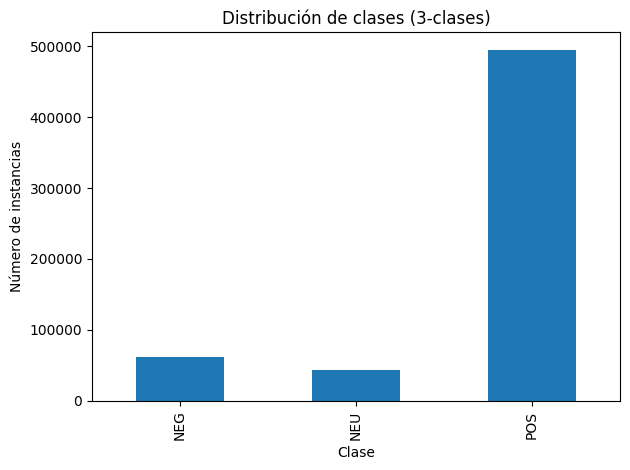

Guardado: reports/eda/20250909_202117/class_distribution.png


In [11]:
# ====== Asegurar LABEL_COLUMN válido (derivar si hace falta) ======
import pandas as pd
import numpy as np

# 1) Detectar texto
TEXT_CANDIDATES = [TEXT_COLUMN, "review_text", "text", "review", "content", "body"]
TEXT_COL = next((c for c in TEXT_CANDIDATES if isinstance(c, str) and c in df.columns), None)
if TEXT_COL is None:
    raise ValueError(f"No se encontró columna de texto. Probadas: {TEXT_CANDIDATES}\nDisponibles: {list(df.columns)[:40]}")

# 2) Si ya existe una etiqueta, úsala; si no, derivamos desde rating
LABEL_CANDIDATES = [LABEL_COLUMN, "sentiment_3c", "label", "sentiment", "target"]
LABEL_CANDIDATES = [c for c in LABEL_CANDIDATES if isinstance(c, str)]
LABEL_COL = next((c for c in LABEL_CANDIDATES if c in df.columns), None)

if LABEL_COL is None:
    # Derivar desde stars/rating
    STAR_CANDIDATES = [STAR_COLUMN, "rating", "stars", "score", "overall", "rating_value"]
    STAR_COL = next((c for c in STAR_CANDIDATES if isinstance(c, str) and c in df.columns), None)
    if STAR_COL is None:
        raise ValueError(f"No hay columna de etiqueta ni de estrellas.\n"
                         f"Probadas etiquetas: {LABEL_CANDIDATES} | Probadas estrellas: {STAR_CANDIDATES}\n"
                         f"Disponibles: {list(df.columns)[:40]}")

    # Normalizar rating a int 1–5
    stars = pd.to_numeric(df[STAR_COL], errors="coerce")
    if stars.max() <= 1.0:  # por si viene 0–1
        stars = (stars * 5)
    stars = stars.round().clip(1, 5).astype("Int64")

    # Mapeo NEG/NEU/POS (usa el del params si existe; si no, fallback)
    _STAR_TO_LABEL = locals().get("STAR_TO_LABEL", {1:"NEG", 2:"NEG", 3:"NEU", 4:"POS", 5:"POS"})
    df["sentiment_3c"] = stars.map(_STAR_TO_LABEL)
    LABEL_COL = "sentiment_3c"
else:
    df[LABEL_COL] = df[LABEL_COL].astype("category")

# 3) Limpieza básica
before = len(df)
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
df[TEXT_COL] = df[TEXT_COL].astype(str)
after = len(df)

# 4) Exponer los nombres para el resto del notebook
LABEL_COLUMN = LABEL_COL
TEXT_COLUMN = TEXT_COL

print(f"OK -> TEXT_COLUMN='{TEXT_COLUMN}' | LABEL_COLUMN='{LABEL_COLUMN}' | Filas eliminadas: {before - after}")
print("Distribución rápida:", df[LABEL_COLUMN].value_counts(dropna=False).to_dict())# ========= Distribución de clases =========
counts = df[LABEL_COLUMN].value_counts().sort_index()
prop = (counts / counts.sum()).round(4)

class_dist = pd.DataFrame({'count': counts, 'ratio': prop})
display(class_dist)

# Guardamos
class_dist_path = REPORT_DIR / 'class_distribution.csv'
class_dist.to_csv(class_dist_path, index=True)
print('Guardado:', class_dist_path)

# Plot
plt.figure()
counts.plot(kind='bar')
plt.title('Distribución de clases (3-clases)')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plot_path = REPORT_DIR / 'class_distribution.png'
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()
print('Guardado:', plot_path)


len_words stats:
count    600648.000000
mean         59.270301
std          42.954060
min           1.000000
50%          49.000000
75%          75.000000
90%         111.000000
95%         140.000000
99%         217.000000
max         974.000000
Name: _len_words, dtype: float64

len_chars stats:
count    600648.000000
mean        313.010932
std         227.732643
min           2.000000
50%         258.000000
75%         396.000000
90%         585.000000
95%         739.000000
99%        1156.000000
max        5508.000000
Name: _len_chars, dtype: float64


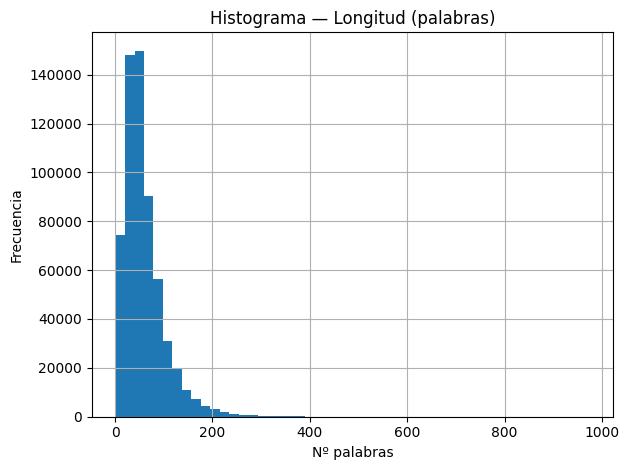

Guardado: reports/eda/20250909_202117/hist_len_words.png


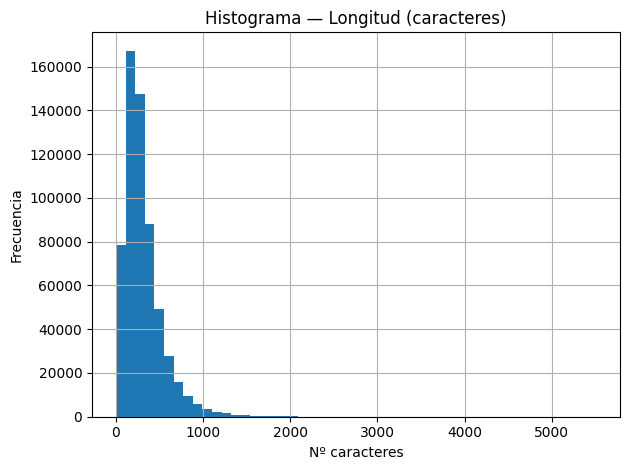

Guardado: reports/eda/20250909_202117/hist_len_chars.png


In [12]:
# ========= Longitudes de texto =========
def basic_word_len(s: str) -> int:
    return len(s.split())

def char_len(s: str) -> int:
    return len(s)

df['_len_words'] = df[TEXT_COLUMN].apply(basic_word_len)
df['_len_chars'] = df[TEXT_COLUMN].apply(char_len)

print('len_words stats:')
print(df['_len_words'].describe(percentiles=[.5, .75, .9, .95, .99]))
print('\nlen_chars stats:')
print(df['_len_chars'].describe(percentiles=[.5, .75, .9, .95, .99]))

# Histograma words
plt.figure()
df['_len_words'].hist(bins=50)
plt.title('Histograma — Longitud (palabras)')
plt.xlabel('Nº palabras')
plt.ylabel('Frecuencia')
lw_path = REPORT_DIR / 'hist_len_words.png'
plt.tight_layout()
plt.savefig(lw_path, dpi=150)
plt.show()
print('Guardado:', lw_path)

# Histograma chars
plt.figure()
df['_len_chars'].hist(bins=50)
plt.title('Histograma — Longitud (caracteres)')
plt.xlabel('Nº caracteres')
plt.ylabel('Frecuencia')
lc_path = REPORT_DIR / 'hist_len_chars.png'
plt.tight_layout()
plt.savefig(lc_path, dpi=150)
plt.show()
print('Guardado:', lc_path)


Cargando tokenizer de HF: albert-base-v2


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


count    5000.000000
mean       76.959200
std        53.640453
min         6.000000
50%        64.000000
75%        97.000000
90%       142.100000
95%       178.050000
99%       276.030000
max       529.000000
Name: _len_hf, dtype: float64


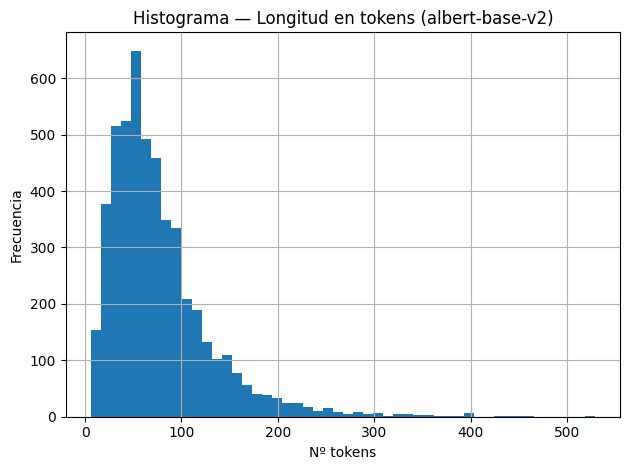

Guardado: reports/eda/20250909_202117/hist_len_tokens_albert-base-v2.png


In [20]:
# ========= (Opcional) Longitud en tokens HF =========
use_hf = HF_MODEL_NAME is not None and AutoTokenizer is not None
if use_hf:
    print('Cargando tokenizer de HF:', HF_MODEL_NAME)
    tok = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
    def hf_len(s: str) -> int:
        return len(tok(s, truncation=False, padding=False)['input_ids'])
    # Muestra para acelerar (opcional)
    sample_size = min(5000, len(df))
    sample = df.sample(sample_size, random_state=42)
    sample = sample.assign(_len_hf=sample[TEXT_COLUMN].apply(hf_len))
    print(sample['_len_hf'].describe(percentiles=[.5, .75, .9, .95, .99]))

    plt.figure()
    sample['_len_hf'].hist(bins=50)
    plt.title(f'Histograma — Longitud en tokens ({HF_MODEL_NAME})')
    plt.xlabel('Nº tokens')
    plt.ylabel('Frecuencia')
    hf_path = REPORT_DIR / f'hist_len_tokens_{HF_MODEL_NAME.replace("/", "_")}.png'
    plt.tight_layout()
    plt.savefig(hf_path, dpi=150)
    plt.show()
    print('Guardado:', hf_path)
else:
    print('Tokenizer HF no configurado. Ajusta eda.hf_model_name en params.yaml para medir tokens reales.')


In [14]:
# ========= Duplicados =========
dup_mask = df.duplicated(subset=[TEXT_COLUMN], keep='first')
n_dups = int(dup_mask.sum())
print(f'Duplicados exactos por texto: {n_dups} ({n_dups/len(df):.2%})')

dups_df = df.loc[dup_mask, [TEXT_COLUMN, LABEL_COLUMN]].head(10)
display(dups_df)

# Guardamos listado (muestra)
dup_path = REPORT_DIR / 'duplicates_sample.csv'
dups_df.to_csv(dup_path, index=False)
print('Guardado:', dup_path)


Duplicados exactos por texto: 92223 (15.35%)


,review_text,sentiment_3c
223,i received this product complimentary for test...,POS
1344,amazing product! i’ve only been using it for a...,POS
1733,for the high price-tag i honestly had high hop...,NEU
2403,i wear waterproof mascara and this removes it ...,POS
2790,it has a smooth creamy consistency. it left my...,POS
3286,very underwhelmed by this product. typically w...,NEG
4353,"i rarely rate products, but i’ve been so impre...",POS
4951,i got a small jar of this in a beauty box and ...,POS
5018,i love yttp products but this one was just oka...,NEU
5477,this is a great balm that gets rid of impuriti...,POS


Guardado: reports/eda/20250909_202117/duplicates_sample.csv


In [15]:
# ========= Limpieza mínima =========
import re, unicodedata

def normalize_text(s: str) -> str:
    # Normaliza Unicode
    s = unicodedata.normalize('NFKC', s)
    # Sustituye múltiples espacios
    s = re.sub(r'\s+', ' ', s).strip()
    # Reducir caracteres repetidos (e.g., 'bueeeno' -> 'bueno')
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)  # permite hasta doble repetición
    return s

df['text_clean'] = df[TEXT_COLUMN].apply(normalize_text)

# Ejemplos antes/después
sample_clean = df[[TEXT_COLUMN, 'text_clean']].head(5)
display(sample_clean)

clean_path = REPORT_DIR / 'sample_cleaning.csv'
sample_clean.to_csv(clean_path, index=False)
print('Guardado:', clean_path)


,review_text,text_clean
0,i received this product for free from influens...,i received this product for free from influens...
1,"decent product for gentle exfoliation, however...","decent product for gentle exfoliation, however..."
2,definitely not one i’d even recommend for comb...,definitely not one i’d even recommend for comb...
3,really enjoy the packaging and product but fin...,really enjoy the packaging and product but fin...
4,melts away eye makeup quickly. i use it as a d...,melts away eye makeup quickly. i use it as a d...


Guardado: reports/eda/20250909_202117/sample_cleaning.csv


_lang
en     4865
unk     127
es        8
Name: count, dtype: int64

Guardado: reports/eda/20250909_202117/lang_counts_sample.csv


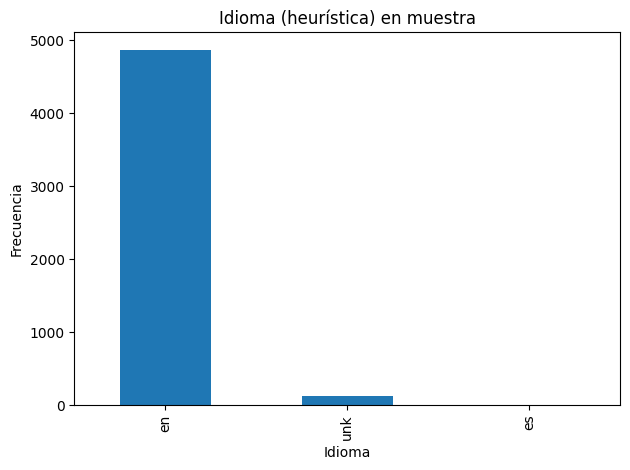

Guardado: reports/eda/20250909_202117/lang_counts_sample.png


In [16]:
# ========= Detección de idioma (heurística simple) =========
def guess_lang_basic(text: str) -> str:
    t = text.lower()
    es_hits = sum(w in t for w in [' el ', ' la ', ' de ', ' que ', ' y '])
    en_hits = sum(w in t for w in [' the ', ' and ', ' is ', ' it ', ' this '])
    if es_hits > en_hits:
        return 'es'
    elif en_hits > es_hits:
        return 'en'
    else:
        return 'unk'

sample_lang = df.sample(min(5000, len(df)), random_state=42).copy()
sample_lang['_lang'] = sample_lang[TEXT_COLUMN].apply(guess_lang_basic)
lang_counts = sample_lang['_lang'].value_counts()
display(lang_counts)

lang_path = REPORT_DIR / 'lang_counts_sample.csv'
lang_counts.to_csv(lang_path)
print('Guardado:', lang_path)

plt.figure()
lang_counts.plot(kind='bar')
plt.title('Idioma (heurística) en muestra')
plt.xlabel('Idioma')
plt.ylabel('Frecuencia')
lang_plot = REPORT_DIR / 'lang_counts_sample.png'
plt.tight_layout()
plt.savefig(lang_plot, dpi=150)
plt.show()
print('Guardado:', lang_plot)


In [17]:
# ========= Sugerencia de max_len =========
p95 = int(np.percentile(df['_len_words'], 95))
p99 = int(np.percentile(df['_len_words'], 99))

recommendation = {
    'words_p95': p95,
    'words_p99': p99,
    'suggested_max_len': int(math.ceil(p95 / 1.0))  # ajusta el factor si quieres ser más conservador
}
print(json.dumps(recommendation, indent=2))

rec_path = REPORT_DIR / 'max_len_recommendation.json'
with open(rec_path, 'w') as f:
    json.dump(recommendation, f, indent=2)
print('Guardado:', rec_path)


{
  "words_p95": 140,
  "words_p99": 217,
  "suggested_max_len": 140
}
Guardado: reports/eda/20250909_202117/max_len_recommendation.json


In [18]:
# ========= Conteo estratificado sugerido (train/val/test) =========
TOTAL = len(df)
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
per_class = df[LABEL_COLUMN].value_counts().sort_index()

split_plan = []
for cls, cnt in per_class.items():
    train_n = int(round(cnt * train_ratio))
    val_n = int(round(cnt * val_ratio))
    test_n = cnt - train_n - val_n
    split_plan.append({'class': cls, 'total': int(cnt), 'train': train_n, 'val': val_n, 'test': test_n})

split_df = pd.DataFrame(split_plan)
display(split_df)

split_path = REPORT_DIR / 'split_plan_counts.csv'
split_df.to_csv(split_path, index=False)
print('Guardado:', split_path)


,class,total,train,val,test
0,NEG,62005,49604,6200,6201
1,NEU,43944,35155,4394,4395
2,POS,494699,395759,49470,49470


Guardado: reports/eda/20250909_202117/split_plan_counts.csv


In [19]:
# ========= Resumen ligero (EDA) =========
summary = {
    'n_rows': int(len(df)),
    'n_cols': int(df.shape[1]),
    'text_column': TEXT_COLUMN,
    'label_column': LABEL_COLUMN,
    'class_distribution': {cls: int(cnt) for cls, cnt in df[LABEL_COLUMN].value_counts().sort_index().items()},
    'len_words_stats': df['_len_words'].describe().to_dict(),
    'len_chars_stats': df['_len_chars'].describe().to_dict(),
    'duplicates_text_pct': float((df.duplicated(subset=[TEXT_COLUMN]).sum()) / len(df))
}

summary_path = REPORT_DIR / 'eda_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print('Guardado:', summary_path)
print('\nListo: revisa la carpeta de reportes para figuras y tablas.')


Guardado: reports/eda/20250909_202117/eda_summary.json

Listo: revisa la carpeta de reportes para figuras y tablas.
